## This code is used to produce figures 3 and 4 in the report

In [1]:
import imageio
import numpy as np
import scipy
from scipy.fftpack import dct
from scipy.signal import correlate
from math import floor, ceil

import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import matplotlib.image as mpimg

from utils import *

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
im1 = imageio.imread('img/test1.png')
im2 = imageio.imread('img/test2.png')
im3 = imageio.imread('img/test3.png')

blocks1 = img_to_blocks(im1)
blocks2 = img_to_blocks(im2)
blocks3 = img_to_blocks(im3)

In [3]:
def get_difference_histograms(blocks):
    "Return the histogram of within and between block differences"
    row_bolcks, col_blocks, _,_ = blocks.shape
    z_rows, z_cols = row_bolcks - 1, col_blocks - 1

    Zp = np.zeros(z_rows * z_cols)
    Zpp = np.zeros(z_rows * z_cols)

    for i in range(z_rows):
        for j in range(z_cols):
            iz = i * z_cols + j

            A = blocks[i,j,3,3]
            B = blocks[i,j,3,4]
            C = blocks[i,j,4,3]
            D = blocks[i,j,4,4]
            Zp[iz] = np.abs(A-B-C+D)

            E = blocks[i, j, 7, 7]
            F = blocks[i, j+1, 7, 0]
            G = blocks[i+1, j, 0, 7]
            H = blocks[i+1, j+1, 0, 0]
            Zpp[iz] = np.abs(E-F-G+H)

    bins=range(
        floor(min(Zp.min(), Zpp.min())),
        ceil(max(Zp.max(), Zpp.max())),
        1
    )

    Hp,_ = np.histogram(Zp, bins=bins, density=True)
    Hpp, _ = np.histogram(Zpp, bins=bins, density=True)
    
    return Hp, Hpp

### Compare the within and between block intensity differences

In [4]:
Hp1, Hpp1 = get_difference_histograms(blocks1)
histdiff1 = np.abs(Hp1 - Hpp1)
Hp2, Hpp2 = get_difference_histograms(blocks2)
histdiff2 = np.abs(Hp2 - Hpp2)
Hp3, Hpp3 = get_difference_histograms(blocks3)
histdiff3 = np.abs(Hp3 - Hpp3)

print(f'IM1 F: {np.sum(histdiff1)}')
print(f'IM2 F: {np.sum(histdiff2)}')
print(f'IM3 F: {np.sum(histdiff3)}')

IM1 F: 0.007811500506425063
IM2 F: 1.1842861910663145
IM3 F: 1.1730650660206785


### Create histogram magnitude plots

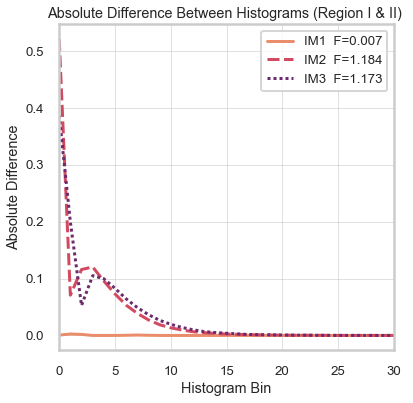

In [18]:
d = {'IM1  F=0.007': histdiff1, 'IM2  F=1.184': histdiff2, 'IM3  F=1.173': histdiff3}

sns.set_context("poster", font_scale = .6, rc={"grid.linewidth": 0.6})
flare = sns.color_palette("flare")
fs = [flare[0], flare[2], flare[5]]

fig3a = plt.figure(figsize=(6,6))
g = sns.lineplot(data=d, palette=fs)

g.set(xlabel='Histogram Bin', ylabel='Absolute Difference')
g.set_title('Absolute Difference Between Histograms (Region I & II) ')
g.set(xlim=(0, 30))

fig3a.savefig('fig3a.svg', format='svg', dpi=1000)

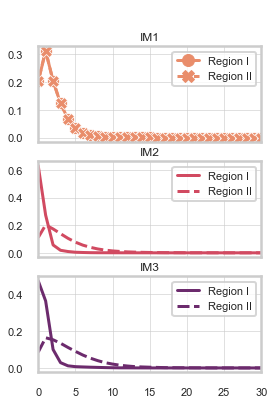

In [17]:
sns.set_context("poster", font_scale = .50, rc={"grid.linewidth": 0.6})
fig3b, ax = plt.subplots(3,1, sharex=True, figsize=(4,6))
plt.text(x=0.5, y=.95, s= "Neighbor Difference Histogram", fontsize=13, ha="center", transform=fig.transFigure)
s1 = sns.lineplot(ax=ax[0], data={'Region I': Hp1, 'Region II': Hpp1}, palette=[fs[0], fs[0]], markers=True)
s1.set(xlim=(0, 30))
s1.set_title('IM1')
s2 = sns.lineplot(ax=ax[1], data={'Region I': Hp2, 'Region II': Hpp2}, palette=[fs[1], fs[1]])
s2.set_title('IM2')
s3 = sns.lineplot(ax=ax[2], data={'Region I': Hp3, 'Region II': Hpp3}, palette=[fs[2], fs[2]])
s3.set_title('IM3')

fig3b.savefig('fig3b.svg', format='svg', dpi=1000)

### Check for the grid origin point of the image

In [19]:
row_bolcks, col_blocks, _,_ = blocks1.shape
z_rows, z_cols = row_bolcks - 1, col_blocks - 1

Zp = np.zeros(z_rows * z_cols)
Zpp = np.zeros(z_rows * z_cols)

for i in range(z_rows):
    for j in range(z_cols):
        iz = i * z_cols + j
            E = blocks[i, j, 7, 7]
            F = blocks[i, j+1, 7, 0]
            G = blocks[i+1, j, 0, 7]
            H = blocks[i+1, j+1, 0, 0]



### Functions to calculate the horizontal and veritical neighbor differences at different grid origins

In [24]:
def E(p, q, image):
    Esum = 0
    for i in range((image.shape[0] // 8) - 1):
        for j in range((image.shape[1] // 8) - 1):
            Esum += abs(image[8*i+p, 8*j+q] - image[8*i+p, 8*j+1+q] - image[8*i+1+p, 8*j+q] + image[8*i+1+p, 8*j+1+q])
    return Esum

def get_offset_grid(image):
    blockdiffs = np.zeros((8,8))

    for p in range(8):
        for q in range(8):
            blockdiffs[p,q] = E(p,q,image)
    
    return blockdiffs

In [25]:
image1 = im1.astype('int')
image2 = im2.astype('int')
image3 = im3.astype('int')

blockdiffs1 = get_offset_grid(image1)
blockdiffs2 = get_offset_grid(image2)
blockdiffs3 = get_offset_grid(image3)

vmax = max(blockdiffs1.max(), blockdiffs2.max(), blockdiffs3.max())
vmin = min(blockdiffs1.min(), blockdiffs2.min(), blockdiffs3.min())

### Create heatmap plot of virtical offsets
- Reflect matrix over secondary diagnol so that grid offset is centered at the origin

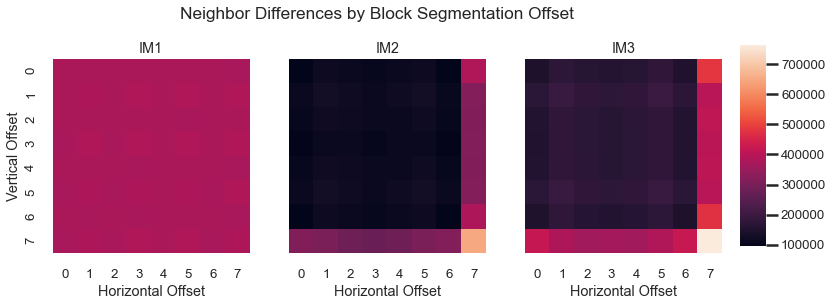

In [67]:
sns.set_context("poster", font_scale = .6, rc={"grid.linewidth": 0.6})
fig4, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))
cbar_ax = fig4.add_axes([.92, .15, .03, .7])

s1 = sns.heatmap(ax=ax[0], data=blockdiffs1, vmin=vmin, vmax=vmax, cbar=False)
s2 = sns.heatmap(ax=ax[1], data=blockdiffs2, vmin=vmin, vmax=vmax, cbar=False)
s3 = sns.heatmap(ax=ax[2], data=blockdiffs3, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)

fig4.suptitle('Neighbor Differences by Block Segmentation Offset')
fig4.subplots_adjust(top=0.8)
s1.set_title('IM1')
s2.set_title('IM2')
s3.set_title('IM3')

s1.set(ylabel='Vertical Offset', xlabel='Horizontal Offset')
s2.set(xlabel='Horizontal Offset')
s3.set(xlabel='Horizontal Offset')

fig4.savefig('fig4.png', format='png', dpi=1000, bbox_inches = "tight")